## Анализ изменения пользовательского спроса для сервиса по покупке билетов Яндекс Афиша

- Автор: Федотова Инна
- Дата: 18.05.2025

## Цели и задачи проекта

Выяснить причины изменения пользовательского спроса. 




## Описание данных

В рамках проекта будем работать с данными датасетов `final_tickets_orders_df.csv` и `final_tickets_events_df.csv`, которые содержат данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количество дней с предыдущей покупки для каждого пользователя

Датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия:

- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Для приведения выручки к одной валюте, будем использовать датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге:

- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## Загрузка данных и знакомство с ними

In [1]:
!pip install matplotlib-venn -q

In [2]:
# Выгружаем библиотеки с которыми будем работать
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib_venn import venn2, venn3 

#Загрузим библиотеку для проведения теста Манна-Уитни
from scipy.stats import mannwhitneyu

#Отключаем предупреждения
import warnings
warnings.simplefilter("ignore")

In [3]:
# Загрузим данные и создадим датафреймы с заказами, событиями и курсами валют
orders_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge_df= pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [4]:
#Посмотрим датафрейм с заказами
orders_df.info()
orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [5]:
#Посмотрим датафрейм с событиями
events_df.info()
events_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [6]:
# Посмотрим датафрейм с данными о курсах валют
tenge_df.info()
display(tenge_df.head(), 
        tenge_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


,data,nominal,curs,cdx
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt
356,2024-12-31,100,19.4860,kzt


В датафрейме с данными о заказах 290849 строк и 14 столбцов. Пропуски есть только в столбце days_since_prev (количество дней с предыдущей покупки для каждого пользователя), тк не все пользователи, повторно совершают покупки. Пропусков около 8%. Столбцы с датой, имеют тип 
object, его нужно будет поменять.



В датафрейме с данными о событиях 22427 строк и 11 столбцов. Пропусков нет.



В датафрейме с данными о курсах валют, представлены данные с 10 января по 31 декабря 2024 года. Пропусков нет, даты в формате object. Можно уменьшить разрядность столбца с номиналом.

## Предобработка данных и подготовка их к исследованию


### Объединение датафреймов

In [7]:
two_df=orders_df.merge(events_df, on='event_id', how='left') 
two_df.info()
two_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [8]:
#Присоединим данные с курсами валют по дате
three_df= two_df.merge(tenge_df, how='left', left_on='created_dt_msk', right_on='data')
three_df.info()
three_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt


После объединения в датафрейме 290849 строк и 28 столбцов. Появились пропуски в столбцах, с данными о событиях, так как объединяли по левому типу, чтобы не потерять данные о заказах. Пропуски означают, что по каким-то идентификаторам событий нет информации.

### Проверка данных на дубликаты

In [9]:
#Проверяем датафрейм на явные дубликаты
three_df.duplicated().sum()

0

Явных дубликатов не обнаружено.


In [10]:
three_df.duplicated(subset=['order_id']).sum()

0

Проверим датасет на неявные дубликаты по бронированию билета без учёта идентификаторов заказа.


In [11]:
duplicates=three_df.duplicated(subset=['user_id', 
                                        'created_dt_msk',
                                        'created_ts_msk', 
                                        'event_id', 
                                        'cinema_circuit',
                                        'age_limit', 
                                        'currency_code', 
                                        'device_type_canonical', 
                                        'revenue', 
                                        'service_name', 
                                        'tickets_count', 
                                        'total',
                                       'event_name', 
                                        'event_type_description',
                                        'event_type_main', 
                                        'organizers', 
                                        'region_name',
                                        'city_name', 
                                        'venue_id', 
                                        'venue_name', 
                                        'venue_address'])

print('Количество неявных дубликатов:', duplicates.sum())
three_df[duplicates].head()

Количество неявных дубликатов: 40


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2024-08-13,100,18.8553,kzt
26896,1930763,0dc525d7bacbb0d,2024-07-31,2024-07-31 13:26:11,393430,нет,18,rub,desktop,1556.05,...,Каменевский регион,Глиногорск,213.0,2704.0,"Летний фестиваль ""Симфония"" Лтд","бул. Боровой, д. 8/1 стр. 43",2024-07-31,100,18.2404,kzt
53717,1935171,206ea45ec11d478,2024-10-29,2024-10-29 16:46:54,442183,нет,16,rub,mobile,601.69,...,Каменевский регион,Глиногорск,213.0,4363.0,"Студия дизайна ""Лестница"" Лимитед","наб. Школьная, д. 9/8 стр. 7/5",2024-10-29,100,20.0429,kzt
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",2024-10-30,100,19.9516,kzt
68215,3326272,2ecf0a4e24cae13,2024-10-17,2024-10-17 15:25:33,481392,нет,18,rub,mobile,40.33,...,Тепляковская область,Горнодолинск,43.0,3873.0,"Клуб истории искусств ""Редкость"" Групп","пр. Маяковского, д. 1",2024-10-17,100,19.9534,kzt


Неявных дубликатов 40, это могло произойти по нескольким причинам:
- пользователь мог случайно несколько раз отправить одну и ту же форму или выполнить одно и то же действие. 
- сбой в системе, который отправил повторно одни и те же данные. 
- ошибка при сборе данных, при которой они могли продублироваться

Так как количество таких дубликатов не большое, то достаточно безболезненным способом их обработки будет удаление.

In [12]:
df_clean = three_df[~duplicates]

print(f"Размер DataFrame до удаления дубликатов: {len(three_df)}")
print(f"Размер DataFrame после удаления дубликатов: {len(df_clean)}")

Размер DataFrame до удаления дубликатов: 290849
Размер DataFrame после удаления дубликатов: 290809


In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290809 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290809 non-null  int64  
 1   user_id                 290809 non-null  object 
 2   created_dt_msk          290809 non-null  object 
 3   created_ts_msk          290809 non-null  object 
 4   event_id                290809 non-null  int64  
 5   cinema_circuit          290809 non-null  object 
 6   age_limit               290809 non-null  int64  
 7   currency_code           290809 non-null  object 
 8   device_type_canonical   290809 non-null  object 
 9   revenue                 290809 non-null  float64
 10  service_name            290809 non-null  object 
 11  tickets_count           290809 non-null  int64  
 12  total                   290809 non-null  float64
 13  days_since_prev         268869 non-null  float64
 14  event_name          

После объединения в датасете образовались пропуски, по событиям, проверим их.

### Проверка данных на пропуски

In [14]:
df_clean.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
data                          0
nominal                       0
curs                          0
cdx                           0
dtype: int64

In [15]:
df_clean.isna().mean()

order_id                  0.000000
user_id                   0.000000
created_dt_msk            0.000000
created_ts_msk            0.000000
event_id                  0.000000
cinema_circuit            0.000000
age_limit                 0.000000
currency_code             0.000000
device_type_canonical     0.000000
revenue                   0.000000
service_name              0.000000
tickets_count             0.000000
total                     0.000000
days_since_prev           0.075445
event_name                0.000818
event_type_description    0.000818
event_type_main           0.000818
organizers                0.000818
region_name               0.000818
city_name                 0.000818
city_id                   0.000818
venue_id                  0.000818
venue_name                0.000818
venue_address             0.000818
data                      0.000000
nominal                   0.000000
curs                      0.000000
cdx                       0.000000
dtype: float64

In [16]:
# Список столбцов, связанных с событиями, в которых есть пропуски
event_columns = [
    'event_name',
    'event_type_description',
    'event_type_main',
    'organizers',
    'region_name',
    'city_name',
    'city_id',
    'venue_id',
    'venue_name',
    'venue_address'
]

# Создаем маску для строк, где хотя бы один из столбцов равен NaN
mask = df_clean[event_columns].isna().any(axis=1)

# Фильтруем DataFrame, чтобы отобразить только строки, соответствующие маске
rows_with_nan = df_clean[mask]
unique_event_ids = rows_with_nan['event_id'].unique()
print(f"Уникальные event_id: {unique_event_ids}")
# Выводим отобранные строки
rows_with_nan.head()

Уникальные event_id: [533222 530296 532300 477731 536716 246804 536731 555671 548224 538260
 534151 536715 539336 553041 553435 548062 572020 559840 505937]


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
62,6493246,002ec276eee9b0b,2024-10-14,2024-10-14 16:27:53,533222,нет,6,rub,mobile,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
63,6493275,002ec276eee9b0b,2024-10-14,2024-10-14 16:22:38,533222,нет,6,rub,mobile,78.75,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
64,6493304,002ec276eee9b0b,2024-10-14,2024-10-14 16:29:20,533222,нет,6,rub,mobile,118.12,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-10-14,100,19.5723,kzt
237,8272280,00da083909dc06b,2024-06-07,2024-06-07 17:50:50,530296,нет,18,rub,mobile,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt
238,8272512,00da083909dc06b,2024-06-07,2024-06-07 17:49:16,530296,нет,18,rub,mobile,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-06-07,100,19.7843,kzt


Доля пропусков в столбце с количеством дней с предыдущей покупки для каждого пользователя составляет 0,075, это говорит о том, что большинство пользователей совершают покупки повторно. 

После объединения появились пропуски, в данных о событиях, тк для некоторых идентификаторов событий из таблицы с заказами, не нашлось подробностей, о таких событиях. Доля таких пропусков крайне мала(менее 1%), для анализа удалим их.

In [17]:
# Удаляем пропуски в событиях и смотрим информацию по датафрейму
df_clean.dropna(subset=event_columns, inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290571 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290571 non-null  int64  
 1   user_id                 290571 non-null  object 
 2   created_dt_msk          290571 non-null  object 
 3   created_ts_msk          290571 non-null  object 
 4   event_id                290571 non-null  int64  
 5   cinema_circuit          290571 non-null  object 
 6   age_limit               290571 non-null  int64  
 7   currency_code           290571 non-null  object 
 8   device_type_canonical   290571 non-null  object 
 9   revenue                 290571 non-null  float64
 10  service_name            290571 non-null  object 
 11  tickets_count           290571 non-null  int64  
 12  total                   290571 non-null  float64
 13  days_since_prev         268658 non-null  float64
 14  event_name          

### Проверка категориальных данных

In [18]:
# Отберем столбцы, с категориями которые нужно проверить
categorical_columns = ['currency_code',
                   'device_type_canonical',
                   'service_name',
                   'event_type_description',
                   'event_type_main']
# Создадим пустой словарь
unique_categories = {}
# Создадим цикл, для вывода уникальных значений столбцов в словарь 
for column in categorical_columns:
    unique_categories[column] = df_clean[column].unique()
    print(f"Уникальные значения для столбца '{column}': {unique_categories[column]}")

Уникальные значения для столбца 'currency_code': ['rub' 'kzt']
Уникальные значения для столбца 'device_type_canonical': ['mobile' 'desktop']
Уникальные значения для столбца 'service_name': ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']
Уникальные значения для столбца 'event_type_description': ['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экску

В категориальных данных не выявлено ошибок.

### Создание новых стобцов

revenue_rub — приведем выручку с заказа к единой валюте — российскому рублю. Для этого используем информацию о курсе казахстанского тенге по отношению к российскому рублю за 2024 год. Значения в рублях представлены для 100 тенге.

one_ticket_revenue_rub — рассчитаем выручку с продажи одного билета на мероприятие.

month — выделим месяц оформления заказа в отдельный столбец.

season — создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [19]:
def calculate_revenue_rub(row):
    """
    Вычисляет выручку в рублях (revenue_rub) для каждой строки
    """
    revenue = row['revenue']
    currency_code = row['currency_code'].lower()  # Приводим к нижнему регистру для надежности

    if currency_code == 'rub':
        return revenue
    elif currency_code == 'kzt':
        return (revenue * row['curs']) / row['nominal']
    else:
        return None  # Или np.nan, если хотите явные пропущенные значения

# Применяем функцию к каждой строке DataFrame
df_clean['revenue_rub'] = df_clean.apply(calculate_revenue_rub, axis=1)

# Проверяем результат
display(df_clean[['revenue', 'currency_code', 'nominal', 'curs', 'cdx', 'revenue_rub']].tail())

# Дополнительно: Проверяем, что все значения revenue_rub заполнены
print(f"\nКоличество пропущенных значений в revenue_rub: {df_clean['revenue_rub'].isna().sum()}")

,revenue,currency_code,nominal,curs,cdx,revenue_rub
290844,965.57,rub,100,19.9266,kzt,965.57
290845,1448.36,rub,100,19.9266,kzt,1448.36
290846,178.95,rub,100,19.9516,kzt,178.95
290847,661.53,rub,100,19.3967,kzt,661.53
290848,802.25,rub,100,19.3262,kzt,802.25



Количество пропущенных значений в revenue_rub: 0


In [20]:
#Создадим столбец с выручкой за 1 билет
df_clean['one_ticket_revenue_rub']=df_clean['revenue_rub']/df_clean['tickets_count']
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700


### Проверка типов данных

In [21]:
#Приведем столбцы с датой и временем к соответствующему типу
for column in ['created_dt_msk', 'created_ts_msk']:
    df_clean[column]=df_clean[column].astype('datetime64[ns]')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290571 entries, 0 to 290848
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290571 non-null  int64         
 1   user_id                 290571 non-null  object        
 2   created_dt_msk          290571 non-null  datetime64[ns]
 3   created_ts_msk          290571 non-null  datetime64[ns]
 4   event_id                290571 non-null  int64         
 5   cinema_circuit          290571 non-null  object        
 6   age_limit               290571 non-null  int64         
 7   currency_code           290571 non-null  object        
 8   device_type_canonical   290571 non-null  object        
 9   revenue                 290571 non-null  float64       
 10  service_name            290571 non-null  object        
 11  tickets_count           290571 non-null  int64         
 12  total                   290571

In [22]:
#Создадим столбец со значением месяца
df_clean['month']=df_clean['created_dt_msk'].dt.month
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_id,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850,8
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250,7
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425,10
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450,7
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700,10


In [23]:
# Функция для определения сезона по месяцу
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'весна'
    elif 6 <= month <= 8:
        return 'лето'
    elif 9 <= month <= 11:
        return 'осень'
    else:
        return 'зима'
    
#Создадим столбец со значением сезона:
df_clean['season'] = df_clean['created_dt_msk'].apply(get_season)
df_clean.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt,1258.57,314.6425,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt,8.49,4.2450,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt,1390.41,463.4700,10,осень


In [24]:
#Создадим функцию для понижения разрядности
def downcast_numeric(df):
    """
    Понижает разрядность типов int64 и float64 в DataFrame для экономии памяти.
    
    """

    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif col_type == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df
# Применим функцию для понжения разрядности ко всему датафрейму и проверим результат
df = downcast_numeric(df_clean)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290571 entries, 0 to 290848
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290571 non-null  int32         
 1   user_id                 290571 non-null  object        
 2   created_dt_msk          290571 non-null  datetime64[ns]
 3   created_ts_msk          290571 non-null  datetime64[ns]
 4   event_id                290571 non-null  int32         
 5   cinema_circuit          290571 non-null  object        
 6   age_limit               290571 non-null  int8          
 7   currency_code           290571 non-null  object        
 8   device_type_canonical   290571 non-null  object        
 9   revenue                 290571 non-null  float32       
 10  service_name            290571 non-null  object        
 11  tickets_count           290571 non-null  int8          
 12  total                   290571

### Проверка числовых данных

In [25]:
#Проверим стоблец с выручкой в рублях по статистическим показателям
df_rub=df[df['currency_code']=='rub'].copy()
df_rub['revenue'].describe()

count    285503.000000
mean        548.023865
std         871.736389
min         -90.760002
25%         114.209999
50%         346.700012
75%         793.320007
max       81174.539062
Name: revenue, dtype: float64

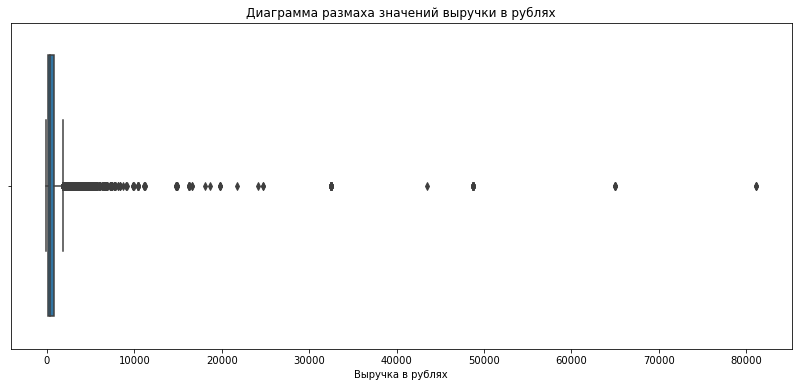

In [26]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.boxplot(x=df_rub['revenue'])  # Строим boxplot
plt.title('Диаграмма размаха значений выручки в рублях')
plt.xlabel('Выручка в рублях')
plt.show()

Видим, что разброс значений достаточно большой. Медиана 346 р., а среднее значение 548 р, на которое влияют выбросы. Основной пласт значений находится в интервале от 114 до 793 р. 
Интересно, что в данных присутствуют отрицательные значения - вероятно так обозначены возвраты. 

Отфильтруем датасет от отрицательных значений и по 99 процентилю.

In [27]:
# Отфильтруем отрицательные значения
df_filtered_rub = df_rub[df_rub['revenue'] > 0]

# Вычислим 99-й процентиль
percentile_99 = df_filtered_rub['revenue'].quantile(0.99)

# Отфильтруем значения, превышающие 99-й процентиль
df_filtered_rub = df_filtered_rub[df_filtered_rub['revenue'] <= percentile_99]
df_filtered_rub['revenue'].describe()

count    276806.000000
mean        521.726440
std         500.611542
min           0.020000
25%         123.462500
50%         355.399994
75%         788.900024
max        2573.770020
Name: revenue, dtype: float64

Теперь данные более равномерные, построим диаграмму распределения значений

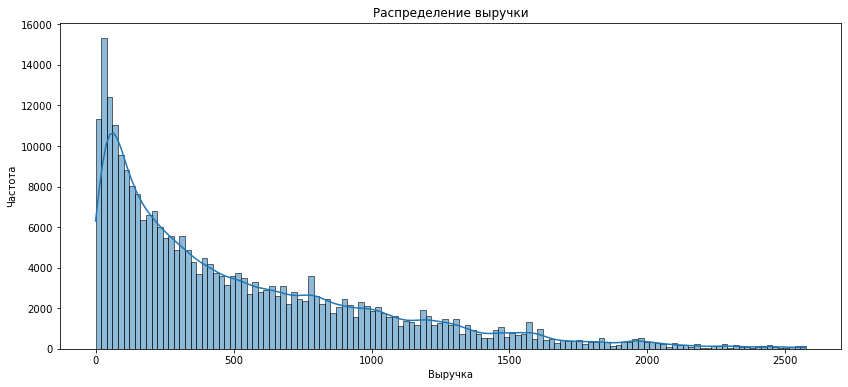

In [28]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.histplot(df_filtered_rub['revenue'], kde=True)  # Строим гистограмму с линией плотности
plt.title('Распределение выручки')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.show()

Распределение выручки экспоненциональное.

In [29]:
#Проверим распределение выручки в тенге
df_kzt=df[df['currency_code']=='kzt']
df_kzt['revenue'].describe()

count     5068.000000
mean      4995.783203
std       4917.006348
min          0.000000
25%        518.099976
50%       3698.830078
75%       7397.660156
max      26425.859375
Name: revenue, dtype: float64

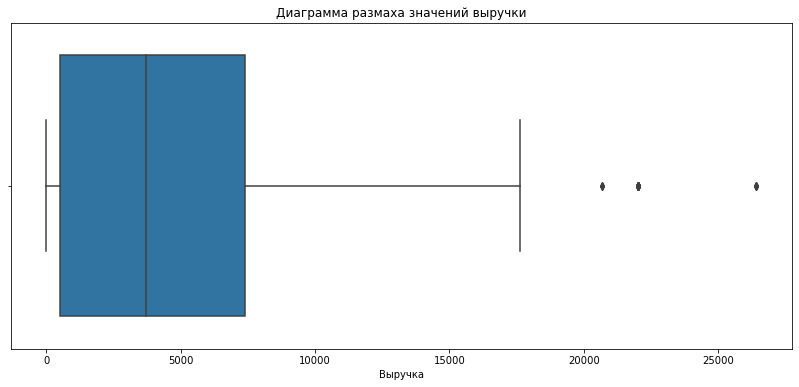

In [30]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.boxplot(x=df_kzt['revenue'])  # Строим boxplot
plt.title('Диаграмма размаха значений выручки')
plt.xlabel('Выручка')
plt.show()

Видим, что выручка в тенге в среднем, с учетом курса валюты, почти в 2 раза больше, чем в рублях, также разброс не такой большой. Отрицательных значений нет, поэтому отфильтруем только выбросы.

In [31]:
# Вычислим 99-й процентиль
percentile_99_kzt = df_kzt['revenue'].quantile(0.99)

# Отфильтруем значения, превышающие 99-й процентиль
df_filtered_kzt = df_kzt[df_kzt['revenue'] <= percentile_99]
df_filtered_kzt['revenue'].describe()

count    2099.000000
mean      703.144958
std       656.320435
min         0.000000
25%       251.229996
50%       410.579987
75%       932.909973
max      2367.760010
Name: revenue, dtype: float64

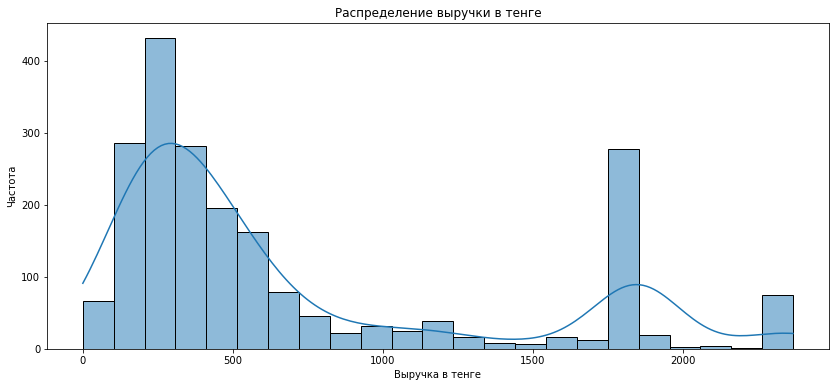

In [32]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.histplot(df_filtered_kzt['revenue'], kde=True)  # Строим гистограмму с линией плотности
plt.title('Распределение выручки в тенге')
plt.xlabel('Выручка в тенге')
plt.ylabel('Частота')
plt.show()

In [33]:
#Объединим датафреймы с отфильтрованными процентилями по значению выручки в разных валютах
df_union= pd.concat([df_filtered_rub, df_filtered_kzt])
df_union.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278905 entries, 0 to 290724
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                278905 non-null  int32         
 1   user_id                 278905 non-null  object        
 2   created_dt_msk          278905 non-null  datetime64[ns]
 3   created_ts_msk          278905 non-null  datetime64[ns]
 4   event_id                278905 non-null  int32         
 5   cinema_circuit          278905 non-null  object        
 6   age_limit               278905 non-null  int8          
 7   currency_code           278905 non-null  object        
 8   device_type_canonical   278905 non-null  object        
 9   revenue                 278905 non-null  float32       
 10  service_name            278905 non-null  object        
 11  tickets_count           278905 non-null  int8          
 12  total                   278905

In [34]:
#Проверим статистику по столбцу с количеством билетов, будем использовать новый датафрейм
df_union['tickets_count'].describe()

count    278905.000000
mean          2.743210
std           1.158926
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

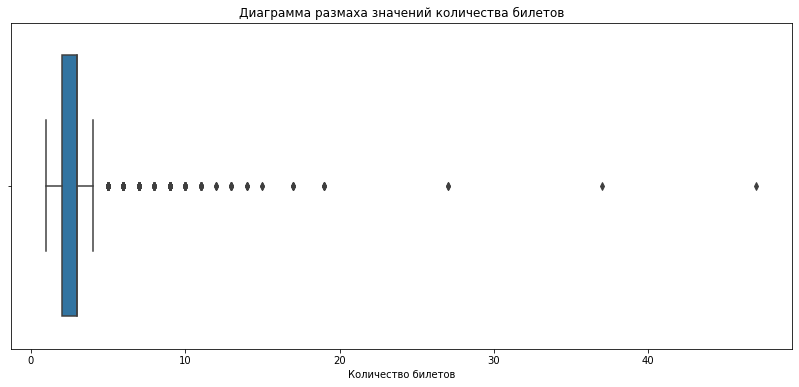

In [35]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.boxplot(x=df_union['tickets_count'])  # Строим boxplot
plt.title('Диаграмма размаха значений количества билетов')
plt.xlabel('Количество билетов')
plt.show()

По статистическим данным видим, что чаще всего пользователи покупают 2-3 билета. Также присутствуют выбросы по количеству билетов, отфильтруем их по 99 процентилю.

In [36]:
# Вычислим 99-й процентиль
percentile_99_tickets = df_union['tickets_count'].quantile(0.99)

# Отфильтруем значения, превышающие 99-й процентиль
df_filtered = df_union[df_union['tickets_count'] <= percentile_99_tickets]
df_filtered['tickets_count'].describe()

count    278731.000000
mean          2.738752
std           1.139139
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64

В целом, средние значения, после фильтрации по 99 процентилю, остались на прежнем уровне 2-3 билета.

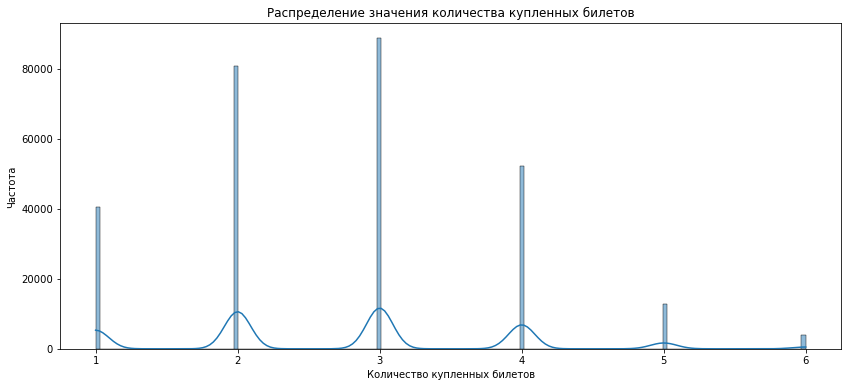

In [37]:
plt.figure(figsize=(14, 6))  # Задаем размер графика
sns.histplot(df_filtered['tickets_count'], kde=True)  # Строим гистограмму с линией плотности
plt.title('Распределение значения количества купленных билетов')
plt.xlabel('Количество купленных билетов')
plt.ylabel('Частота')
plt.show()

По гистограмме видим, что чаще всего пользователи покупают 2-3 билета. 

In [38]:
#Проверим датафрейм после всех преобразований
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278731 entries, 0 to 290724
Data columns (total 32 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                278731 non-null  int32         
 1   user_id                 278731 non-null  object        
 2   created_dt_msk          278731 non-null  datetime64[ns]
 3   created_ts_msk          278731 non-null  datetime64[ns]
 4   event_id                278731 non-null  int32         
 5   cinema_circuit          278731 non-null  object        
 6   age_limit               278731 non-null  int8          
 7   currency_code           278731 non-null  object        
 8   device_type_canonical   278731 non-null  object        
 9   revenue                 278731 non-null  float32       
 10  service_name            278731 non-null  object        
 11  tickets_count           278731 non-null  int8          
 12  total                   278731

In [39]:
# Посчитаем долю срезанных данных
percent_clean=round(1-df_filtered['order_id'].count()/three_df['order_id'].count(),2)
percent_clean

0.04

После предобработки количество строк снизилось с 290849 до 278731, так как мы отсекли выбросы, не явные дубликаты и заказы по которым нет данных о типе события, чтобы они не исказили дальнейший анализ. Разница составляет 4% от всех данных. Также мы объединили датафреймы и создали 4 новых столбца, поэтому в новом датафрейме 32 столбца.

- `revenue_rub` — выручка с заказа в рублях.

- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.

- `month` — месяц оформления заказа.

- `season` — сезон сделанного заказа, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

Были обработаны типы данных, разрядность, количество пропусков. 

По итогу можно использовать обработанный датафрейм `df_filtered` для анализа.

## Исследовательский анализ данных
### Анализ распределения заказов по сегментам и их сезонные изменения
 
 


- Найдем для каждого месяца количество заказов и визуализируем их.


In [40]:
#Сгруппируем по месяцам и посчитаем количество заказов для каждого месяца
group_month= df_filtered.groupby('month')['order_id'].count().reset_index()
group_month

,month,order_id
0,6,30721
1,7,37664
2,8,42885
3,9,68684
4,10,98777


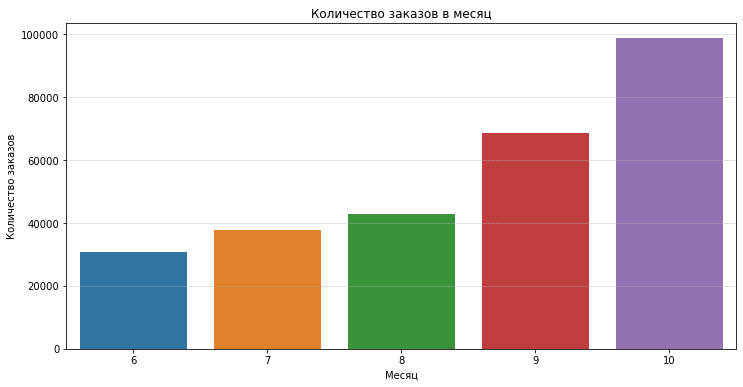

In [41]:
#Построим график распределения заказов по месяцам
plt.figure(figsize=(12,6))
sns.barplot(x='month', y='order_id', data=group_month)
plt.title('Количество заказов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.show()

Видим, что с каждым месяцем количество заказов растет. В сентябре и октябре мы наблюдаем сильный подьем. Количество заказов в сентябре увеличилось на 1/3 по сравнению с августом. В октябре количество заказов достигло рекорда за все время - 98777.

Вероятно, увеличение количества заказов с сентября связано с сезонностью, тк закончился период отпусков, дач и каникул.

- Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

In [42]:
#Сгруппируем заказы по сезону и посчитаем количество заказов
total_season= df_filtered.groupby('season')['order_id'].count().reset_index(name='total_in_season')
total_season

,season,total_in_season
0,лето,111270
1,осень,167461


In [43]:
#Теперь сгруппируем по сезону и по типу мероприятия
count_event_type= df_filtered.groupby(['season','event_type_main'])['order_id'].count().reset_index(name='count')

# Объединяем count_event_type и total_season для расчета доли
grp_event_type = pd.merge(count_event_type, total_season, on='season')

#Считаем долю
grp_event_type['proportion']= grp_event_type['count']/grp_event_type['total_in_season']
grp_event_type

,season,event_type_main,count,total_in_season,proportion
0,лето,выставки,2407,111270,0.021632
1,лето,другое,28354,111270,0.254822
2,лето,концерты,47445,111270,0.426395
3,лето,спорт,2758,111270,0.024787
4,лето,стендап,6343,111270,0.057005
5,лето,театр,23690,111270,0.212906
6,лето,ёлки,273,111270,0.002453
7,осень,выставки,2402,167461,0.014344
8,осень,другое,32577,167461,0.194535
9,осень,концерты,62407,167461,0.372666


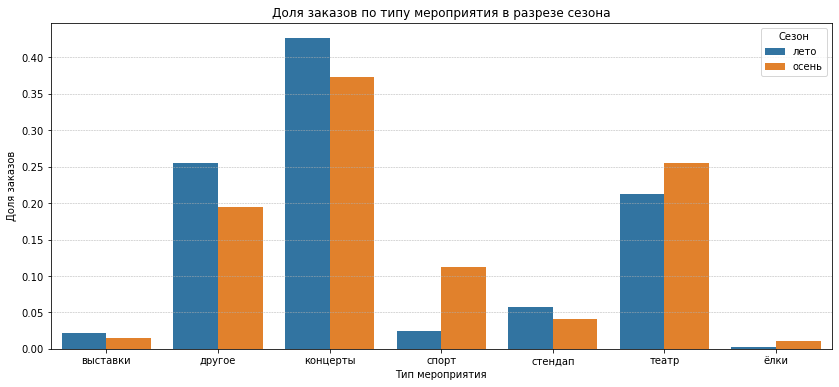

In [44]:
#Построим график распределения доли заказов по типам мероприятия для лета и осени
plt.figure(figsize=(14,6))

sns.barplot(x='event_type_main', y='proportion', hue='season', data=grp_event_type)
plt.title('Доля заказов по типу мероприятия в разрезе сезона')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Сезон')
plt.show()

Видим осенью повышенный интерес к спортивным мероприятиям, театральным представлениям и к ёлкам. При этом, для концертов, стендапа, выставок и 'других' мероприятий доля заказов осенью снизилась.
Такое распределение может быть также связано с сезоном. Например летом, чаще проходят концерты под открытым небом, туристы посещают выставки. Осенью, пользователи выбирают мероприятия в помещениях и в их городе (театры), начинают готовиться к зимним елкам. Ну а спортивные мероприятия, чаще всего также начинают свой сезон с осени.

In [45]:
#сгруппируем по сезону и по девайсу
count_device_type= df_filtered.groupby(['season','device_type_canonical'])['order_id'].count().reset_index(name='count')

# Объединяем count_device_type и total_season для расчета доли
grp_device_type = pd.merge(count_device_type, total_season, on='season')

#Считаем долю
grp_device_type['proportion']= grp_device_type['count']/grp_device_type['total_in_season']

grp_device_type

,season,device_type_canonical,count,total_in_season,proportion
0,лето,desktop,20852,111270,0.187400
1,лето,mobile,90418,111270,0.812600
2,осень,desktop,34109,167461,0.203683
3,осень,mobile,133352,167461,0.796317


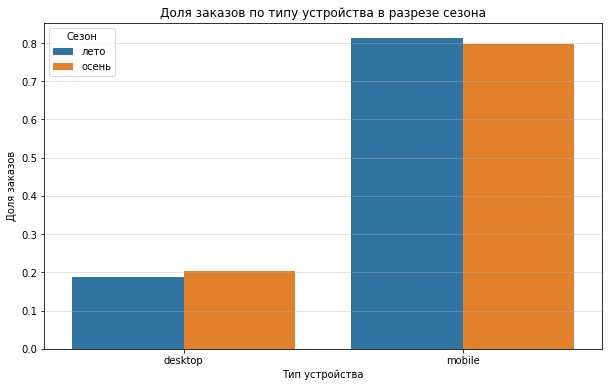

In [46]:
#Построим график распределения доли заказов по типам устройства для лета и осени

plt.figure(figsize=(10,6))

sns.barplot(x='device_type_canonical', y='proportion', hue='season', data=grp_device_type)
plt.title('Доля заказов по типу устройства в разрезе сезона')
plt.xlabel('Тип устройства')
plt.ylabel('Доля заказов')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Сезон')
plt.show()

Доля заказов в разрезе типов устройств по сезонам, практически не изменилась. Доля заказов с ПК осенью выросла примерно на 2%, а доля заказов с мобильных устройств снизилась на 2%. 
Рост доли заказов с ПК также может быть связан с тем, что пользователи вернулись на работу, где им удобнее заказывать билеты с компьютера.

In [47]:
#сгруппируем по сезону и по возрастному цензу
count_age_limit= df_filtered.groupby(['season','age_limit'])['order_id'].count().reset_index(name='count')

# Объединяем count_age_limit и total_season для расчета доли
grp_age_limit = pd.merge(count_age_limit, total_season, on='season')

#Считаем долю
grp_age_limit['proportion']= grp_age_limit['count']/grp_age_limit['total_in_season']

grp_age_limit

,season,age_limit,count,total_in_season,proportion
0,лето,0,20647,111270,0.185558
1,лето,6,20878,111270,0.187634
2,лето,12,22806,111270,0.204961
3,лето,16,31194,111270,0.280345
4,лето,18,15745,111270,0.141503
5,осень,0,39255,167461,0.234413
6,осень,6,29618,167461,0.176865
7,осень,12,37004,167461,0.220971
8,осень,16,44095,167461,0.263315
9,осень,18,17489,167461,0.104436


In [48]:
# Создадим сводную таблицу для построения графика
pivot=grp_age_limit.pivot(index='age_limit', columns='season', values='proportion')
pivot

season,лето,осень
age_limit,,
0,0.185558,0.234413
6,0.187634,0.176865
12,0.204961,0.220971
16,0.280345,0.263315
18,0.141503,0.104436


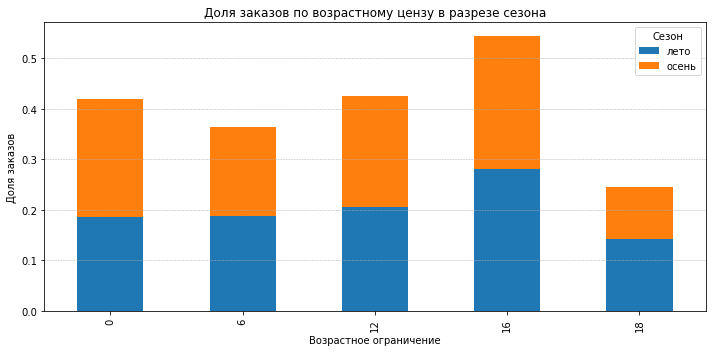

In [49]:
#Построим график с долей заказов в разных возрастных категориях, в разрезе по сезонам
pivot.plot(kind='bar', stacked=True, figsize=(10, 5))

plt.xlabel('Возрастное ограничение')
plt.ylabel('Доля заказов')
plt.title('Доля заказов по возрастному цензу в разрезе сезона')
plt.legend(title='Сезон')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Выросла доля заказов для мероприятий 0+ и 12+, доля заказов для остальных возрастов уменьшилась. При этом, стоит учитывать, что разница составляет не более 5%. 

Это может быть связано с тем, что закончились летные каникулы и родители стали чаще покупать детям билеты на различные мероприятия.


- Проверим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью

In [50]:
#Сгруппируем по сезону и по типу мероприятия
mean_event_type= df_filtered.groupby(['season','event_type_main'])['one_ticket_revenue_rub'].mean().reset_index(name='mean')
mean_event_type=mean_event_type.sort_values(by='mean', ascending=False)
mean_event_type

,season,event_type_main,mean
2,лето,концерты,295.147278
6,лето,ёлки,271.436188
9,осень,концерты,267.610046
11,осень,стендап,231.124969
13,осень,ёлки,229.564209
4,лето,стендап,218.484283
5,лето,театр,216.397858
12,осень,театр,176.098770
7,осень,выставки,91.905090
1,лето,другое,87.333923


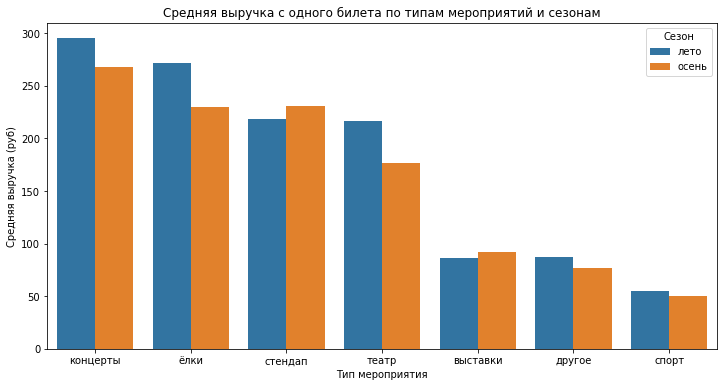

In [51]:
#Столбчатая диаграмма средней выручки по типам мероприятий и сезонам
plt.figure(figsize=(12, 6))
sns.barplot(x='event_type_main', y='mean', hue='season', data=mean_event_type)
plt.title('Средняя выручка с одного билета по типам мероприятий и сезонам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка (руб)')
plt.legend(title='Сезон')
plt.show()

Видим, что в абсолютном значении средняя выручка за 1 билет увеличилась осенью только для выставок и стендапов. Все остальные категории показывают уменьшение выручки осенью.

In [52]:
# Создание сводной таблицы (pivot table) для расчета относительного изменения выручки
pivot_table = mean_event_type.pivot_table(index='event_type_main', columns='season', values='mean')

# Расчет относительного изменения (изменение в процентах)
pivot_table['difference'] = ((pivot_table['осень'] - pivot_table['лето']) / pivot_table['лето']) * 100
pivot_table

season,лето,осень,difference
event_type_main,,,
выставки,86.744476,91.905090,5.949214
другое,87.333923,77.201889,-11.601487
концерты,295.147278,267.610046,-9.329997
спорт,55.195580,50.250080,-8.959956
стендап,218.484283,231.124969,5.785627
театр,216.397858,176.098770,-18.622683
ёлки,271.436188,229.564209,-15.426085


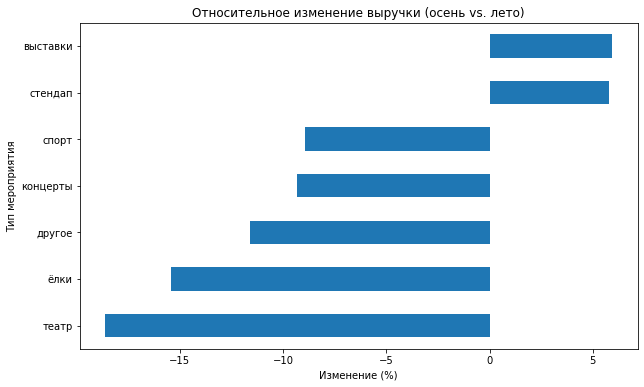

In [53]:
# Горизонтальная столбчатая диаграмма относительного изменения
plt.figure(figsize=(10, 6))
pivot_table['difference'].sort_values().plot(kind='barh')  # Сортируем для лучшей читаемости
plt.title('Относительное изменение выручки (осень vs. лето)')
plt.xlabel('Изменение (%)')
plt.ylabel('Тип мероприятия')
plt.show()

В относительном значении также наблюдаем осеннюю просадку размера выручки, почти по всем категориям, кроме выставок и стендапа.

Анализ заказов показал, что с каждым месяцем количество заказов стабильно растет. В сентябре и октябре мы наблюдаем сильный подьем. Количество заказов в сентябре увеличилось на 1/3 по сравнению с августом. В октябре количество заказов достигло рекорда за все время - 98777.

Вероятно, увеличение количества заказов с сентября связано с сезонностью, тк закончился период отпусков, дач и каникул.

Осенью увеличилась доля заказов билетов для спортивных мероприятий, театральных представлений и ёлок. При этом, для концертов, стендапа, выставок и 'других' мероприятий доля заказов осенью снизилась.
Такое распределение может быть также связано с сезоном. Например летом, чаще проходят концерты под открытым небом, туристы посещают выставки. Осенью, пользователи выбирают мероприятия в помещениях и в их городе (театры), начинают готовиться к зимним елкам. Ну а многие спортивные мероприятия, чаще всего также начинают свой сезон с осени.


Доля заказов в разрезе типов устройств по сезонам, с ПК осенью выросла примерно на 2%, а доля заказов с мобильных устройств снизилась на эти же 2%. Рост доли заказов с ПК также может быть связан с тем, что пользователи вернулись на работу, где им удобнее заказывать билеты с компьютера.


Выросла доля заказов для мероприятий 0+ и 12+, доля заказов для остальных возрастов уменьшилась. При этом, стоит учитывать, что разница составляет не более 5%.


В абсолютном и относительном значении средняя выручка за 1 билет осенью уменьшилась для всех типов мероприятий, кроме выставок и стендапов.





### Осенняя активность пользователей
 
Изучим активность пользователей осенью 2024 года. 

Проанализируем динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

In [54]:
# Фильтрация данных за осень 2024 года
df_autumn = df_filtered[(df_filtered['season'] == 'осень')]

#Сгруппируем отфильтрованные данные по дням и посчитаем метрики
grp_autumn=df_autumn.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    total_revenue=('revenue_rub', 'sum'),
    total_tickets=('tickets_count', 'sum')
).reset_index()

#Расчет дополнительных метрик
grp_autumn['orders_per_user'] = grp_autumn['total_orders'] / grp_autumn['dau']
grp_autumn['avg_ticket_price'] = grp_autumn['total_revenue'] / grp_autumn['total_tickets']

grp_autumn.head()

,created_dt_msk,total_orders,dau,total_revenue,total_tickets,orders_per_user,avg_ticket_price
0,2024-09-01,1314,555,7.262059e+05,3683.0,2.367568,197.177827
1,2024-09-02,1356,565,6.890416e+05,3647.0,2.400000,188.933798
2,2024-09-03,5078,770,1.143540e+06,15206.0,6.594805,75.203226
3,2024-09-04,1746,680,8.475783e+05,4732.0,2.567647,179.116296
4,2024-09-05,1912,730,9.657408e+05,5107.0,2.619178,189.101393


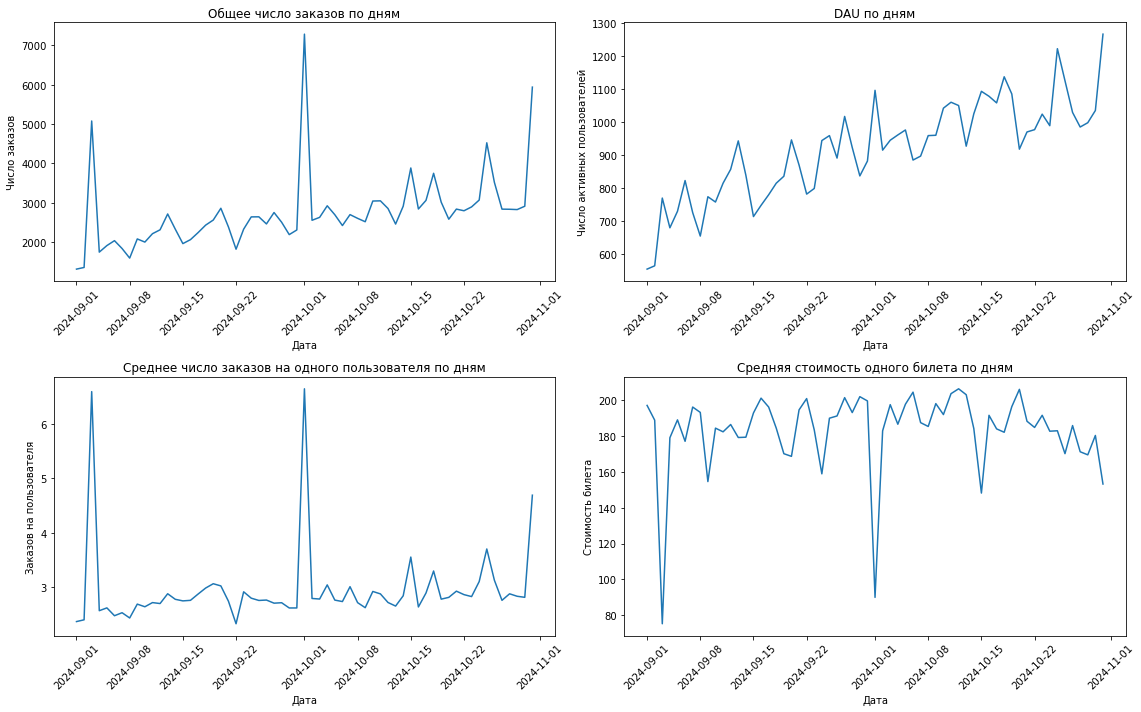

In [55]:
# 3. Визуализация динамики по дням
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))  # 2x2 subplots

# Общее число заказов
sns.lineplot(ax=axes[0, 0], x='created_dt_msk', y='total_orders', data=grp_autumn)
axes[0, 0].set_title('Общее число заказов по дням')
axes[0, 0].set_xlabel('Дата')
axes[0, 0].set_ylabel('Число заказов')
axes[0, 0].tick_params(axis='x', rotation=45)

# DAU
sns.lineplot(ax=axes[0, 1], x='created_dt_msk', y='dau', data=grp_autumn)
axes[0, 1].set_title('DAU по дням')
axes[0, 1].set_xlabel('Дата')
axes[0, 1].set_ylabel('Число активных пользователей')
axes[0, 1].tick_params(axis='x', rotation=45)

# Среднее число заказов на одного пользователя
sns.lineplot(ax=axes[1, 0], x='created_dt_msk', y='orders_per_user', data=grp_autumn)
axes[1, 0].set_title('Среднее число заказов на одного пользователя по дням')
axes[1, 0].set_xlabel('Дата')
axes[1, 0].set_ylabel('Заказов на пользователя')
axes[1, 0].tick_params(axis='x', rotation=45)

# Средняя стоимость одного билета
sns.lineplot(ax=axes[1, 1], x='created_dt_msk', y='avg_ticket_price', data=grp_autumn)
axes[1, 1].set_title('Средняя стоимость одного билета по дням')
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Стоимость билета')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Автоматическая регулировка расположения графиков
plt.show()

По графикам видим, что количество уникальных пользователей неравномерно, но растет.
Также мы видим явную закономерность: 3 сентября и 1 октября, стоимость билета существенно снизилась (с 180 до 80 рублей), что привело к скачкам в количестве заказов (их стало более 15 000, при обычном среднем уровне 2000-4000 заказов) и среднем количестве заказов на пользователя(показатель вырос с 2-3 билетов на пользователя, до 5-7.

Возможно это какой-то баг, доступный группе пользователей или акция со слишком большой скидкой, которая привлекает перекупщиков. Нужно дополнительно проверить причну такого снижения цены за билеты и по возможности исправить. Так как, хоть это и приводит к значительному увеличению количества заказов, но практически не отражается на выручке и не влияет на количество новых уникальных пользователей.

- Изучим недельную цикличность. Проверим, отличается ли активность пользователей в будни и в выходные.

In [56]:
# Добавлим столбец с днем недели
df_autumn['day_of_week'] = df_autumn['created_dt_msk'].dt.day_name()  
#Создадим столбец с признаком выходного дня
df_autumn['is_weekend'] = df_autumn['created_dt_msk'].dt.dayofweek > 4  
df_autumn.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season,day_of_week,is_weekend
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,2024-10-06,100,19.647499,kzt,1258.569946,314.642487,10,осень,Sunday,True
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,2024-10-04,100,19.664801,kzt,1390.410034,463.470001,10,осень,Friday,False
5,2613713,000898990054619,2024-10-23,2024-10-23 15:12:00,500862,нет,12,rub,mobile,902.739990,...,2024-10-23,100,20.053101,kzt,902.739990,300.913330,10,осень,Wednesday,False
7,4657981,000a55a418c128c,2024-09-29,2024-09-29 19:39:12,265857,нет,12,rub,mobile,47.779999,...,2024-09-29,100,19.374100,kzt,47.779999,47.779999,9,осень,Sunday,True
8,4657952,000a55a418c128c,2024-10-15,2024-10-15 10:29:04,271579,нет,12,rub,mobile,74.839996,...,2024-10-15,100,19.718500,kzt,74.839996,37.419998,10,осень,Tuesday,False


In [57]:
# Группировка по дню недели и расчет числа заказов
grp_week = df_autumn.groupby('day_of_week').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique')
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']) 
grp_week['orders_per_user'] = grp_week['total_orders'] / grp_week['dau']
grp_week

,total_orders,dau,orders_per_user
day_of_week,,,
Monday,21424,4419,4.848156
Tuesday,31358,4769,6.575383
Wednesday,22757,4797,4.744007
Thursday,26990,4943,5.460247
Friday,24609,4822,5.103484
Saturday,21142,4508,4.689885
Sunday,19181,4330,4.429792


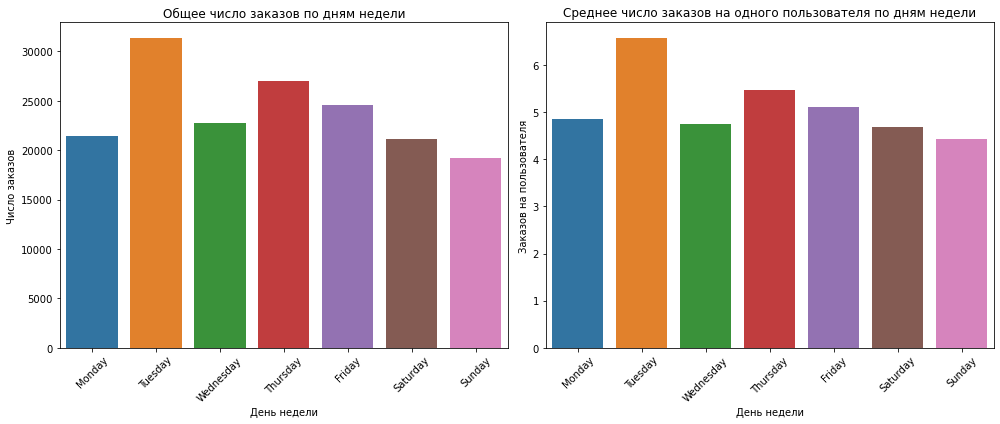

In [58]:
# Визуализация недельной активности
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.barplot(ax=axes[0], x=grp_week.index, y='total_orders', data=grp_week)
axes[0].set_title('Общее число заказов по дням недели')
axes[0].set_xlabel('День недели')
axes[0].set_ylabel('Число заказов')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x=grp_week.index, y='orders_per_user', data=grp_week)
axes[1].set_title('Среднее число заказов на одного пользователя по дням недели')
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Заказов на пользователя')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Видим, что выходные - не самые активные дни для пользователей, покупающих билеты. Наиболее активны пользователи по вторникам и четвергам.

In [59]:
# Сравнение пользовательской активности в будни и выходные
weekend_vs_weekday = df_autumn.groupby('is_weekend').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique')
)
weekend_vs_weekday['orders_per_user'] = weekend_vs_weekday['total_orders'] / weekend_vs_weekday['dau']
weekend_vs_weekday.index = ['Будни', 'Выходные'] 

weekend_vs_weekday

,total_orders,dau,orders_per_user
Будни,127138,13138,9.677120
Выходные,40323,7049,5.720386


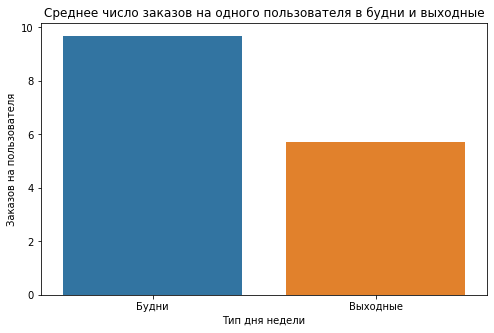

In [60]:
# Визуализация активности в будни и выходные
plt.figure(figsize=(8, 5))
sns.barplot(x=weekend_vs_weekday.index, y='orders_per_user', data=weekend_vs_weekday)
plt.title('Среднее число заказов на одного пользователя в будни и выходные')
plt.xlabel('Тип дня недели')
plt.ylabel('Заказов на пользователя')
plt.show()

Среднее количество заказов на пользователя, в будние дни, превышает количество аналогичных заказов в выходные.

В выходные пользователи менее активны, чем в будние дни. Самые активные пользовательские дни - вторник и четверг.

### Популярные события и партнёры
- Посмотрим уникальное количество мероприятий и общее число заказов для каждого региона

In [61]:
# Агрегация данных по регионам
grp_region = df_filtered.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index().sort_values(by='total_orders', ascending=False)
grp_region.head(15)

,region_name,unique_events,total_orders
23,Каменевский регион,5792,85372
60,Североярская область,3774,43473
77,Широковская область,1217,16082
42,Медовская область,462,13582
45,Озернинский край,349,10403
57,Светополянский округ,1059,7462
41,Малиновоярский округ,165,6314
52,Речиновская область,701,6264
64,Солнечноземская область,520,6234
78,Яблоневская область,534,6119


Видим что Каменевский регион по количеству заказов является абсолютным лидером с отрывом от второго места почти в 2 раза. По числу уникальных событий, этот регион также впереди. На втором и третьем месте Североярская и Широковская области.

Интересно, что количество уникальных событий не всегда напрямую коррелирует с количеством заказов. Например, в Медовской области 462 уникальных события, а заказов 13582, а в Светополянском округе 1059 событий, но заказов уже 7462.

In [62]:
# Расчет долей
total_events = grp_region['unique_events'].sum()
total_orders = grp_region['total_orders'].sum()
grp_region['event_share'] = grp_region['unique_events'] / total_events
grp_region['order_share'] = grp_region['total_orders'] / total_orders
grp_region.head(10)

,region_name,unique_events,total_orders,event_share,order_share
23,Каменевский регион,5792,85372,0.263368,0.306288
60,Североярская область,3774,43473,0.171608,0.155968
77,Широковская область,1217,16082,0.055338,0.057697
42,Медовская область,462,13582,0.021008,0.048728
45,Озернинский край,349,10403,0.015869,0.037323
57,Светополянский округ,1059,7462,0.048154,0.026771
41,Малиновоярский округ,165,6314,0.007503,0.022653
52,Речиновская область,701,6264,0.031875,0.022473
64,Солнечноземская область,520,6234,0.023645,0.022366
78,Яблоневская область,534,6119,0.024282,0.021953


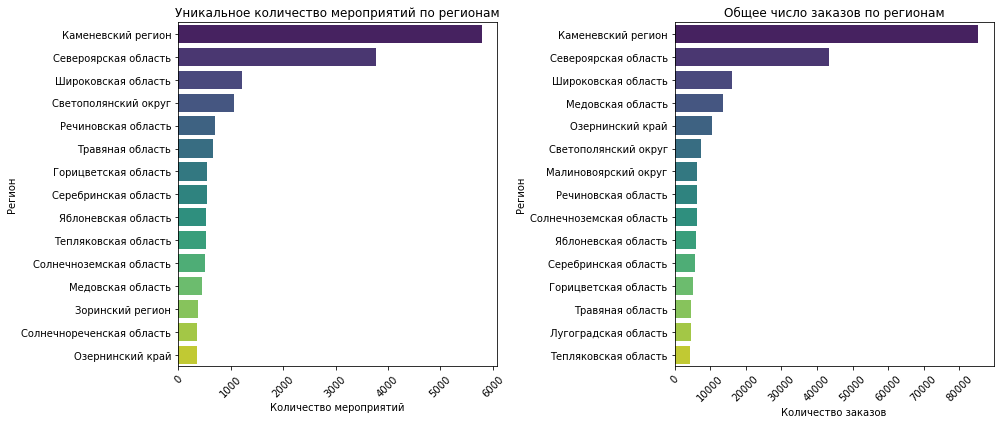

In [63]:
# Визуализация 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

sns.barplot(ax=axes[0], x='unique_events', y='region_name', data=grp_region.sort_values(by='event_share', ascending=False).head(15), palette='viridis')
axes[0].set_title('Уникальное количество мероприятий по регионам')
axes[0].set_ylabel('Регион')
axes[0].set_xlabel('Количество мероприятий')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='total_orders', y='region_name', data=grp_region.sort_values(by='order_share', ascending=False).head(15), palette='viridis')
axes[1].set_title('Общее число заказов по регионам')
axes[1].set_ylabel('Регион')
axes[1].set_xlabel('Количество заказов')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Каменевский регион по количеству заказов и уникальных событий является абсолютным лидером с большим отрывом от второго места, на него приходится 30% от всех заказов. На втором месте Североярская область с 15% заказов и на третьем - Широковская область с 5%.

Количество уникальных событий не всегда напрямую коррелирует с количеством заказов. 
Например, в Медовской области 462 уникальных события, а заказов 13582, а в Светополянском округе 1059 событий, но заказов уже 7462.

- Проанализируем выручку, число уникальных событий и кольчество заказов для каждого билетного партнёра

In [64]:
# Агрегация данных по билетным партнерам
grp_partner = df.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('revenue_rub', 'sum')
).reset_index().sort_values(by='total_revenue', ascending=False)

# Расчет долей
total_events = grp_partner['unique_events'].sum()
total_orders = grp_partner['total_orders'].sum()
total_revenue = grp_partner['total_revenue'].sum()

grp_partner['event_share'] = grp_partner['unique_events'] / total_events
grp_partner['order_share'] = grp_partner['total_orders'] / total_orders
grp_partner['revenue_share'] = round(grp_partner['total_revenue'] / total_revenue,2)
# Форматирование столбца 'revenue'
grp_partner['total_revenue'] = grp_partner['total_revenue'].apply(lambda x: f'{x:,.0f}')
grp_partner

,service_name,unique_events,total_orders,total_revenue,event_share,order_share,revenue_share
3,Билеты без проблем,4255,63503,"26,698,926",0.173908,0.218546,0.17
24,Мой билет,1308,34835,"23,476,516",0.053460,0.119885,0.15
25,Облачко,2348,26642,"21,644,068",0.095966,0.091688,0.13
8,Весь в билетах,867,16848,"18,048,418",0.035435,0.057982,0.11
21,Лови билет!,4882,41118,"17,663,366",0.199534,0.141508,0.11
5,Билеты в руки,3538,40336,"13,384,190",0.144603,0.138816,0.08
19,Край билетов,253,6207,"6,703,959",0.010340,0.021361,0.04
26,Прачечная,1027,10273,"4,900,986",0.041975,0.035355,0.03
13,Дом культуры,274,4502,"4,676,648",0.011199,0.015494,0.03
35,Яблоко,716,5039,"3,971,152",0.029264,0.017342,0.02


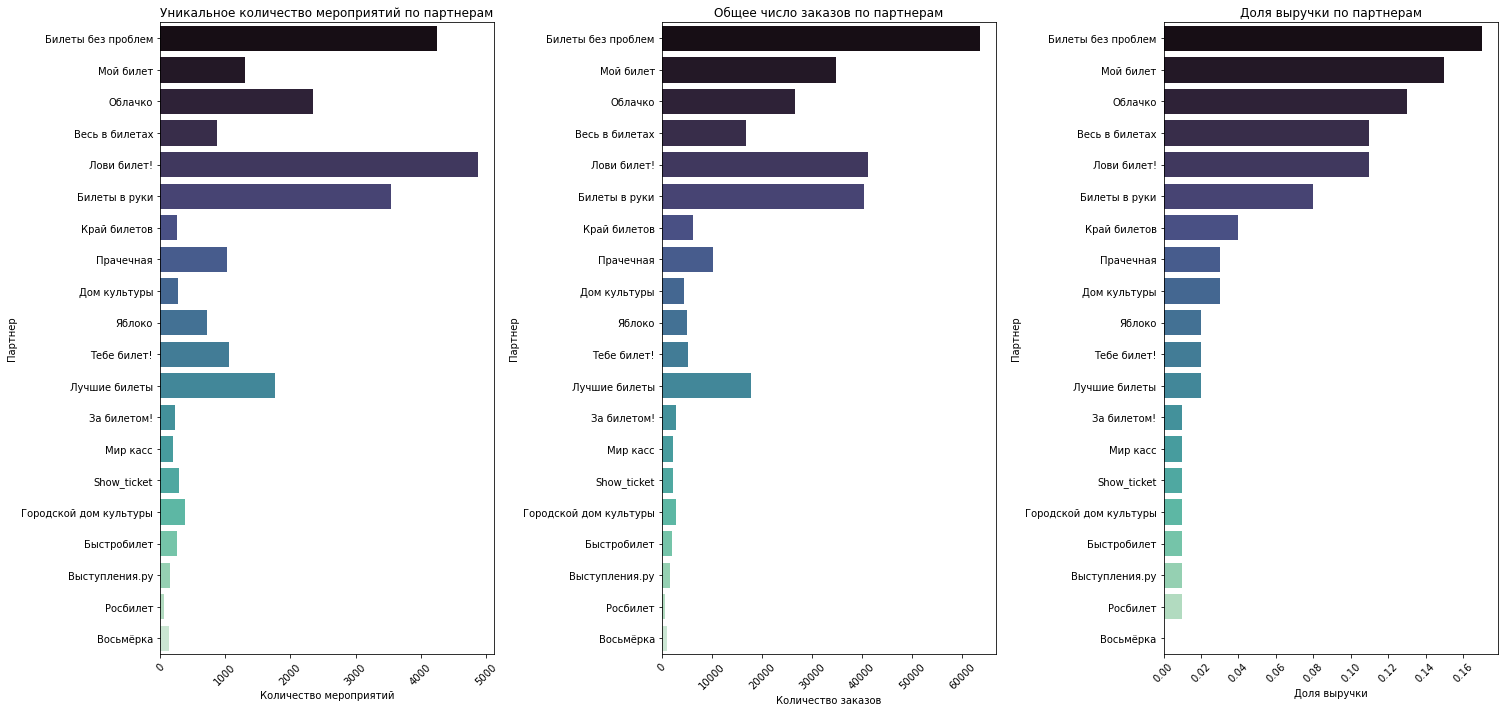

In [65]:
# Визуализация 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 10))

sns.barplot(ax=axes[0], x='unique_events', y='service_name', data=grp_partner.head(20), palette='mako')
axes[0].set_title('Уникальное количество мероприятий по партнерам')
axes[0].set_ylabel('Партнер')
axes[0].set_xlabel('Количество мероприятий')
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[1], x='total_orders', y='service_name', data=grp_partner.head(20), palette='mako')
axes[1].set_title('Общее число заказов по партнерам')
axes[1].set_ylabel('Партнер')
axes[1].set_xlabel('Количество заказов')
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(ax=axes[2], x='revenue_share', y='service_name', data=grp_partner.head(20), palette='mako')
axes[2].set_title('Доля выручки по партнерам')
axes[2].set_ylabel('Партнер')
axes[2].set_xlabel('Доля выручки')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Топ-5 по партнерам:
1. "Билеты без проблем" - 17 % от общей выручки
2. "Мой билет" - 15%
3. "Облачко" - 13%
4. "Весь в билетах" - 11%
5. "Лови билет!"	- 11%

Здесь также большое количество уникальных событий не гарантирует большого количества заказов или высокую выручку. Например, у сервиса "Мой билет" 1308 событий и 34835 заказов, а у сервиса "Облачко" 2348 событий и 26642 заказов.

Еще любопытно, что большое количество заказов, не всегда указывает на высокую выручку. Например сервис "Билеты в руки" при числе заказов - 40336, имеет выручку 13,384,190, а сервис "Весь в билетах" с	16848 заказов имеет выручку	18,048,418.

Топ-3 Регионов по количеству заказов и их доля:
1. Каменевский регион 30%
2. Североярская область 15%
3. Широковская область 5%

Топ-5 партнеров по размеру выручки и их доле:

1. "Билеты без проблем" 17 %
2. "Мой билет" 15%
3. "Облачко" 13%

## Статистический анализ данных
### Проверка гипотезы: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Проверим и подготовим данные для проведения теста.

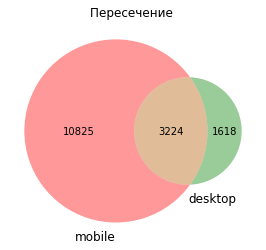

count    18891.000000
mean         8.864592
std         61.429251
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       4313.000000
Name: order_id, dtype: float64

In [66]:
# Сгруппируем данные по идентификатору пользователя и устройства
orders_per_user = df_autumn.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()

#Отберем пользователей мобильных устройств и ПК
mobile=orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']
desktop=orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']

#Потроим диаграмму Венна, чтобы проверить пересечение пользователей разных устройств
first_id = set(mobile['user_id'].unique())
second_id = set(desktop['user_id'].unique())
# Строим диаграмму Венна
venn2([first_id, second_id], set_labels=('mobile', 'desktop'))

# Отображаем график
plt.title("Пересечение ")
plt.show()

display(orders_per_user['order_id'].describe())

По графику видим, что есть пользователи, которые пользуются и мобильным устройством и компьютером, чтобы не исказились результаты теста - отфильтруем таких пользователей.

Также интересно, что есть пользователь, который совершил 4313 заказов, проверим его срок жизни.

In [67]:
# Вычисляем id пользователя , с максимальным количеством заказов
max_orders_user=orders_per_user.loc[orders_per_user['order_id'].idxmax()]

# Узнаем, сколько этот пользователь пользуется сервисом
client_lifetime=df_filtered.groupby('user_id').agg(first_day=('created_dt_msk','min'), last_day=('created_dt_msk','max')).reset_index()

client_lifetime['client_lifetime']=client_lifetime['last_day']-client_lifetime['first_day']

life_of_max_user=client_lifetime[client_lifetime['user_id']==max_orders_user['user_id']]
life_of_max_user

,user_id,first_day,last_day,client_lifetime
968,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,152 days


Есть пользователь с id 0beb8fc0c0a9ce1, который совершил 4313 заказа, за осенний период. Обычный пользователь, не покупает билеты на мероприятия в таком количестве. Судя по сроку жизни, пользователь все время на сервисе. Похоже, что это один из перекупщиков билетов, которые в начале сентября и октября, сильно увеличили количество заказов билетов по маленькой цене. Вероятно, стоит предпринять какие-то ограничительные меры для таких пользователей.

In [68]:
# Сгруппируем осенний датафрейм по идентификатору пользователя и посчитаем количество уникальных значений девайса
cnt_device=df_autumn.groupby('user_id').agg({'device_type_canonical':'nunique'}).reset_index()
# Выделим пользователей, у которых уникальное количество девайсов =1
filter_users=cnt_device[cnt_device['device_type_canonical']==1]['user_id']

# Отфильтруем датафрейм по таким пользователям
orders_filter_users=df_autumn[df_autumn['user_id'].isin(filter_users)]

# Создадим датасет с подсчетом количества заказов
orders_filter_users= orders_filter_users.groupby(['user_id', 'device_type_canonical'])['order_id'].count().reset_index()
orders_filter_users['order_id'].describe()

count    12443.000000
mean         2.751587
std          4.036216
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

In [69]:
# Создаем 2 выборки для пользователей телефона и ПК
mobile_orders = orders_filter_users[orders_filter_users['device_type_canonical'] == 'mobile']['order_id']
desktop_orders = orders_filter_users[orders_filter_users['device_type_canonical'] == 'desktop']['order_id']

# Проверим распределение данных выборок
display(mobile_orders.describe(),
        desktop_orders.describe())

count    10825.000000
mean         2.867621
std          4.150233
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

count    1618.000000
mean        1.975278
std         3.059401
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_id, dtype: float64

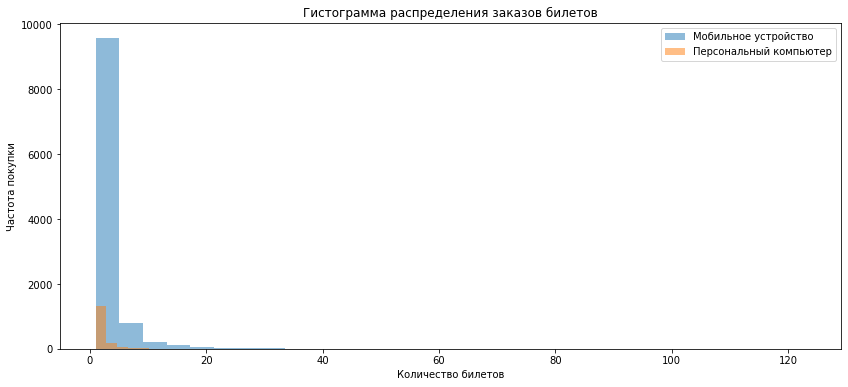

In [70]:
#Построим гистограмму раcпределения данных для двух выьорок
plt.figure(figsize=(14, 6))
plt.hist(mobile_orders, bins=30, label='Мобильное устройство', alpha=0.5)
plt.hist(desktop_orders, bins=30, label='Персональный компьютер', alpha=0.5)

plt.xlabel('Количество билетов')
plt.ylabel('Частота покупки')

plt.title('Гистограмма распределения заказов билетов')
plt.legend()
plt.show()

Видим, что у выборок экспоненциальное распределение, присутствуют аномалии, также выборка пользователей с мобильными устройствами в разы превышает выборку пользователей ПК, поэтому для проверки гипотезы будем использовать тест Манна-Уитни.

Сформулируем гипотезу:
* H0 (нулевая гипотеза): Среднее количество заказов на одного пользователя мобильного приложения не отличается от среднего количества заказов на одного пользователя стационарных устройств.
* H1 (альтернативная гипотеза): Среднее количество заказов на одного пользователя мобильного приложения выше, чем среднее количество заказов на одного пользователя стационарных устройств.

Уровень значимости установим стандартный =5%

In [71]:
# Установим уровень значимости
alpha = 0.05 

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    mobile_orders, 
    desktop_orders, 
    alternative='greater' # alternative='greater' соответствует альтернативной гипотезе: Dist(a)>Dist(b)
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Нет статистически значимых доказательств того, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на стационарных устройствах.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Есть статистически значимые доказательства того, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на стационарных устройствах.')


pvalue=1.7233254691245022e-38 < 0.05
Нулевая гипотеза не находит подтверждения! Есть статистически значимые доказательства того, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на стационарных устройствах.


По данным осеннего периода, согласно проведенному тесту Манна-Уитни, мы выяснили, что есть статистически значимые доказательства того, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на стационарных устройствах.

### Проверка гипотезы: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Подготовим и проверим данные для проверки гипотезы. Для анализа будем использовать столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя.

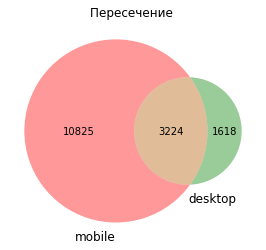

count    14125.000000
mean        18.939215
std         26.585785
min          0.000000
25%          1.571429
50%          7.769231
75%         24.600000
max        148.000000
Name: days_since_prev, dtype: float64

In [72]:
# Сгруппируем данные по идентификатору пользователя и устройства
time_between_orders = df_autumn.groupby(['user_id', 'device_type_canonical'])['days_since_prev'].mean().reset_index()

#Отберем пользователей мобильных устройств и ПК
grp_mobile=time_between_orders[time_between_orders['device_type_canonical'] == 'mobile']
grp_desktop=time_between_orders[time_between_orders['device_type_canonical'] == 'desktop']

#Потроим диаграмму Венна, чтобы проверить пересечение пользователей разных устройств
first_id = set(grp_mobile['user_id'].unique())
second_id = set(grp_desktop['user_id'].unique())
# Строим диаграмму Венна
venn2([first_id, second_id], set_labels=('mobile', 'desktop'))

# Отображаем график
plt.title("Пересечение ")
plt.show()

display(time_between_orders['days_since_prev'].describe())

Снова наблюдаем пересечение по пользователям, отфильтруем их для того чтобы результаты анализа не исказились. 

In [73]:
# Сгруппируем осенний датафрейм по идентификатору пользователя и посчитаем количество уникальных значений девайса
unique_device=time_between_orders.groupby('user_id').agg({'device_type_canonical':'nunique'}).reset_index()
# Выделим пользователей, у которых уникальное количество девайсов =1
users_filtered=unique_device[unique_device['device_type_canonical']==1]['user_id']

# Отфильтруем датафрейм по таким пользователям и Nan в столбце days_since_prev
time_between=time_between_orders[time_between_orders['user_id'].isin(users_filtered)]
time_between= time_between[time_between['days_since_prev'].notna()]

# Создадим датасет с подсчетом среднего времени между заказами
time_between= time_between.groupby(['user_id', 'device_type_canonical'])['days_since_prev'].mean().reset_index()
display(time_between,
        time_between['days_since_prev'].describe())

,user_id,device_type_canonical,days_since_prev
0,0005ca5e93f2cf4,mobile,75.000000
1,000898990054619,mobile,51.000000
2,000a55a418c128c,mobile,16.000000
3,001e7037d013f0f,mobile,43.500000
4,00245c702bc343e,mobile,27.500000
...,...,...,...
7889,ffe364dd8211157,mobile,41.333332
7890,ffe73c50cbd71fc,mobile,0.000000
7891,ffed3ff067d4f12,mobile,26.000000
7892,fff13b79bd47d7c,mobile,20.666666


count    7894.000000
mean       25.884443
std        30.981037
min         0.000000
25%         2.200000
50%        14.000000
75%        38.000000
max       148.000000
Name: days_since_prev, dtype: float64

In [74]:
#Создадаим выборки для проверки гипотезы

mobile_times = time_between[time_between['device_type_canonical'] == 'mobile']['days_since_prev']
desktop_times = time_between[time_between['device_type_canonical'] == 'desktop']['days_since_prev']

display(mobile_times.describe(),
       desktop_times.describe())

count    6994.000000
mean       25.216688
std        30.163239
min         0.000000
25%         2.953416
50%        14.000000
75%        36.000000
max       148.000000
Name: days_since_prev, dtype: float64

count    900.000000
mean      31.073654
std       36.325726
min        0.000000
25%        0.000000
50%       16.000000
75%       52.500000
max      146.000000
Name: days_since_prev, dtype: float64

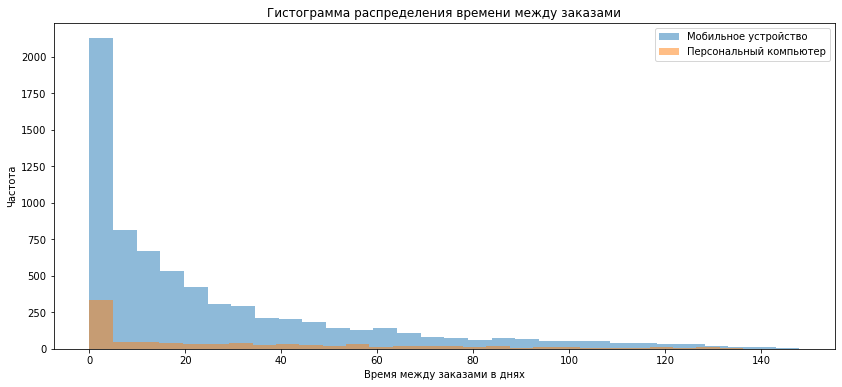

In [75]:
#Построим гистограмму раcпределения данных для двух выборок
plt.figure(figsize=(14, 6))
plt.hist(mobile_times, bins=30, label='Мобильное устройство', alpha=0.5)
plt.hist(desktop_times, bins=30, label='Персональный компьютер', alpha=0.5)

plt.xlabel('Время между заказами в днях')
plt.ylabel('Частота')

plt.title('Гистограмма распределения времени между заказами')
plt.legend()
plt.show()

Выборки распределены экспоненциально, данные характеризуюся достаточно большим разбросом. Также выборки достаточно разных размеров.
Для таких выборок подходит тест Манна-Уитни.

Сформулируем гипотезу:

- H0 (нулевая гипотеза): Среднее время между заказами пользователей мобильного приложения не отличается от среднего времени между заказами пользователей со стационарных устройств.
- H1 (альтернативная гипотеза): Среднее время между заказами пользователей мобильного приложения выше, чем среднее время между заказами пользователей стационарных устройств.

Уровень значимости установим стандартный =5%

In [76]:
# Установим уровень значимости
alpha = 0.05 

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    mobile_times, 
    desktop_times, 
    alternative='greater' # alternative='greater' соответствует альтернативной гипотезе: Dist(a)>Dist(b)
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Нет статистически значимых доказательств того, что среднее время между заказами пользователей мобильного приложения выше, чем на стационарных устройствах.')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Есть статистически значимые доказательства того, что среднее время между заказами пользователей мобильного приложения выше, чем на стационарных устройствах.')

pvalue=0.7665427731452972 > 0.05
Нулевая гипотеза находит подтверждение! Нет статистически значимых доказательств того, что среднее время между заказами пользователей мобильного приложения выше, чем на стационарных устройствах.


По данным осеннего периода, согласно проведенному тесту Манна-Уитни, нет статистически значимых доказательств того, что среднее время между заказами пользователей мобильного приложения выше, чем на стационарных устройствах.

## Общий вывод и рекомендации

### Загрузка данных и знакомство с ними


В датафрейме с данными о заказах 290849 строк и 14 столбцов. Пропуски есть только в столбце days_since_prev (количество дней с предыдущей покупки для каждого пользователя), тк не все пользователи, повторно совершают покупки. Пропусков около 8%.

В датафрейме с данными о событиях 22427 строк и 11 столбцов. Пропусков нет.

В датафрейме с данными о курсах валют, представлены данные с 10 января по 31 декабря 2024 года. Пропусков нет.


### Предобработка данных и подготовка к исследованию

- Объединили датафреймы 

- Проверили данные на дубликаты и удалили 40 неявных дубликатов. 
Размер датафрейма после удаления дубликатов: 290809
- Обработали пропуски. После объединения датафреймов появились пропуски, в данных о событиях, тк для некоторых идентификаторов событий из таблицы с заказами, не нашлось подробностей, о таких событиях. Доля таких пропусков крайне мала(менее 1%), для анализа удалили их. 

Доля пропусков в столбце с количеством дней с предыдущей покупки для каждого пользователя составляет 0,075. Пропуски в поле связаны с особенностью вычисления данных для этого столбца, эти пропуски оставили как есть.

- В категориальных данных ошибки/опечатки/дубликаты не найдены

- Создали новые столбцы:

`revenue_rub` — выручка с заказа в рублях

`one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.

`month` — месяц оформления заказа.

`season` — информация о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

- проверили и скорректировали типы данных, понизили разрядность для экономии памяти

- статистически проверили числовые данные в столбцах revenue и tickets_count, отфильтровали выбросы по 99 процентилю

Средняя выручка с билета, после фильтрации в рублях 521 р., медиана 355,  в тенге - 703, медиана - 410.

Чаще всего пользователи покупают 2-3 билета. 


После предобработки количество строк снизилось с 290849 до 278731, так как мы отсекли выбросы, не явные дубликаты и заказы по которым нет данных о типе события.

### Исследовательский анализ данных
1. Анализ распределения заказов по сегментам и их сезонные изменения
 
С каждым месяцем количество заказов растет. В сентябре и октябре мы наблюдаем сильный подьем. Количество заказов в сентябре увеличилось на 1/3 по сравнению с августом. В октябре количество заказов достигло рекорда за все время - 98777.

Вероятно, увеличение количества заказов с сентября связано с сезонностью, тк закончился период отпусков, дач и каникул.

Осенью повышенный интерес к спортивным мероприятиям, театральным представлениям и к ёлкам. При этом, для концертов, стендапа, выставок и 'других' мероприятий доля заказов осенью снизилась.
Такое распределение может быть также связано с сезоном. Например летом, чаще проходят концерты под открытым небом, туристы посещают выставки. Осенью, пользователи выбирают мероприятия в помещениях и в их городе (театры), начинают готовиться к зимним елкам. Ну а спортивные мероприятия, чаще всего также начинают свой сезон с осени.

Доля заказов в разрезе типов устройств по сезонам, практически не изменилась. Доля заказов с ПК осенью выросла примерно на 2%, а доля заказов с мобильных устройств снизилась на 2%. 
Рост доли заказов с ПК также может быть связан с тем, что пользователи вернулись на работу, где им удобнее заказывать билеты с компьютера.

Выросла доля заказов для мероприятий 0+ и 12+, доля заказов для остальных возрастов уменьшилась. При этом, стоит учитывать, что разница составляет не более 5%. 

Это может быть связано с тем, что закончились летные каникулы и родители стали чаще покупать детям билеты на различные мероприятия.

В абсолютном и относительном значении средняя выручка за 1 билет осенью уменьшилась для всех типов мероприятий, кроме выставок и стендапов.

2. Осенняя активность пользователей

Количество уникальных пользователей неравномерно, но растет.
3 сентября и 1 октября, стоимость билета существенно снизилась (примерно до 80 рублей), что привело к скачкам в количестве заказов (их стало более 15 000, при обычном среднем уровне 2000-4000 заказов) и среднем количестве заказов на пользователя(показатель вырос с 2-3 билетов на пользователя, до 5-7).

Возможно это какой-то баг, доступный группе пользователей или акция со слишком большой скидкой, которая привлекает перекупщиков. Нужно дополнительно проверить причну такого снижения цены за билеты и по возможности исправить. Так как, хоть это и приводит к значительному увеличению количества заказов, но практически не отражается на выручке и не влияет на количество новых уникальных пользователей.

Также далее мы нашли пользователя, который за осенний период заказал более 4000 билетов, что не характерно для среднестатистического покупателя.

В выходные пользователи менее активны, чем в будние дни. Самые активные пользовательские дни - вторник и четверг.

3. Популярные регионы и партнёры

Топ-3 Регионов по количеству заказов и их доля:

Каменевский регион 30%
Североярская область 15%
Широковская область 5%

Количество уникальных событий не всегда напрямую коррелирует с количеством заказов. 
Например, в Медовской области 462 уникальных события, а заказов 13582, а в Светополянском округе 1059 событий, но заказов уже 7462.

Топ-5 по партнерам:
1. "Билеты без проблем" - 17 % от общей выручки
2. "Мой билет" - 15%
3. "Облачко" - 13%
4. "Весь в билетах" - 11%
5. "Лови билет!" - 11%
Здесь также большое количество уникальных событий не гарантирует большого количества заказов или высокую выручку. Например, у сервиса "Мой билет" 1308 событий и 34835 заказов, а у сервиса "Облачко" 2348 событий и 26642 заказов.
Еще любопытно, что большое количество заказов, не всегда указывает на высокую выручку. Например сервис "Билеты в руки" при числе заказов - 40336, имеет выручку 13,384,190, а сервис "Весь в билетах" с 16848 заказов имеет выручку 18,048,418.

### Статистический анализ данных

- Проверяем гипотезу:

H0 (нулевая гипотеза): Среднее количество заказов на одного пользователя мобильного приложения не отличается от среднего количества заказов на одного пользователя стационарных устройств.
H1 (альтернативная гипотеза): Среднее количество заказов на одного пользователя мобильного приложения выше, чем среднее количество заказов на одного пользователя стационарных устройств.

 Для проведения теста убрали пользователей, которые совершают заказы и с мобильного приложения и со стационарного утройства.
Для проверки гипотезы выбран тест Манна-Уитни, тк данные распределены экспоненциально и имеют большие хвосты.

По данным осеннего периода, согласно проведенному тесту Манна-Уитни, мы выяснили, что есть статистически значимые доказательства того, что среднее количество заказов на одного пользователя мобильного приложения выше, чем на стационарных устройствах.

- Проверяем гипотезу:

H0 (нулевая гипотеза): Среднее время между заказами пользователей мобильного приложения не отличается от среднего времени между заказами пользователей со стационарных устройств.
H1 (альтернативная гипотеза): Среднее время между заказами пользователей мобильного приложения выше, чем среднее время между заказами пользователей стационарных устройств.

Для проведения теста убрали пользователей, которые совершают заказы и с мобильного приложения и со стационарного утройства.
Для проверки гипотезы выбран тест Манна-Уитни, тк данные распределены экспоненциально и имеют большие хвосты.

По данным осеннего периода, согласно проведенному тесту Манна-Уитни, нет статистически значимых доказательств того, что среднее время между заказами пользователей мобильного приложения выше, чем на стационарных устройствах.

### Рекомендации
Осенний период показывает высокую активность пользователей,  поэтому можно к осени готовить специальные предложения. Также при запуске, стоит учитывать что пользователи наиболее активны по вторникам и четвергам.

По акциям нужно проверить, нет ли такой, которая слишком сильно занижает цену билета, тк это приводит к привлечению перекупщиков и несмотря на высокое количество заказов, выручка не растет.

Дополнительно можн проверить, причину просадки выручки почти во всех категориях, возможно нужно переходить на накопительные бонусные программы, а не скидки за билеты.

Также можно направить усилия, на развитие инфраструктуры мероприятий в регионах, так как по доле выручки, только 3 региона максимально вовлечены.

В результате проверки гипотез, мы выяснили, что среднее количество заказов на одного пользователя в приложении больше чем на стационарных устройствах.
Таким образом, можно построить маркетинговую кампанию на привлечение пользователей в приложение, с предложением бонусных программ, для увеличения количества постоянных покупателей, совершающих много заказов.


